<a href="https://colab.research.google.com/github/armandoordonez/deeplearning/blob/main/TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importación de librerías y dataset**

In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

Vamos a utilizar uno de los datasets que tiene tensorflow por defecto. Hemos seleccionado el fashion_mnist. Ustedes pueden probar esta practica con alguno de estos datasets: mnist, cifar10, cifar100.
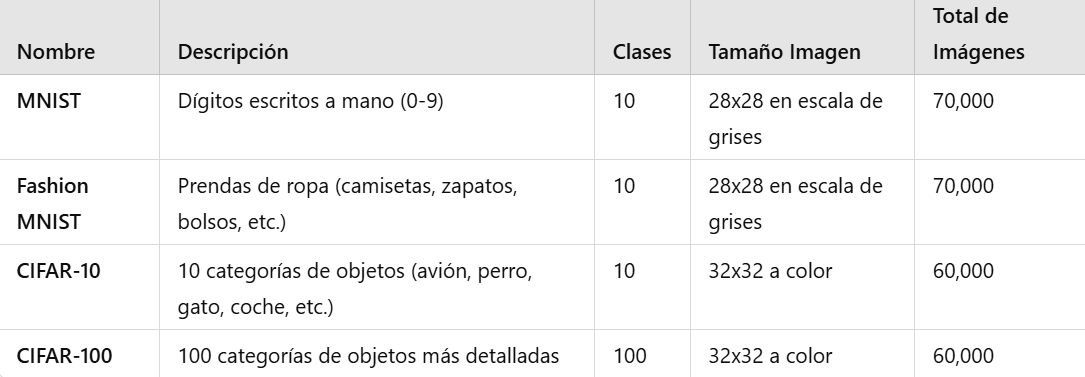

In [ ]:
#Aqui deben colocar el dataset que van a utilizar. En nuestro caso, usaremos fashion_mnist
from tensorflow.keras.datasets import fashion_mnist

# **División de datos: train y test**

In [ ]:
# Cargar dataset.
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalizar imágenes.
x_train, x_test = x_train / 255.0, x_test / 255.0

# Ver información del dataset
print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")
print(f"Clases únicas: {set(y_train.flatten())}")

Train shape: (60000, 28, 28), Test shape: (10000, 28, 28)
Clases únicas: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [ ]:
#Vamos a cambiar esas etiquetas númericas con valores, para comprender y analizar de mejor manera el dataset.

#Ustedes deben cambiar las etiquetas acuerdo al dataset seleccionado. En nuestro caso, seleccionamos un dataset de ropa.

# Diccionario de etiquetas
label_map = {
    0: "Camiseta/Top",
    1: "Pantalón",
    2: "Suéter",
    3: "Vestido",
    4: "Abrigo",
    5: "Sandalia",
    6: "Camisa",
    7: "Zapatilla",
    8: "Bolso",
    9: "Bota"
}

# Convertir las etiquetas numéricas a texto
y_train_text = np.array([label_map[label] for label in y_train])
y_test_text = np.array([label_map[label] for label in y_test])

# Mostrar algunas etiquetas convertidas
print(y_train_text[:10])  # Muestra las primeras 10 etiquetas en texto

['Bota' 'Camiseta/Top' 'Camiseta/Top' 'Vestido' 'Camiseta/Top' 'Suéter'
 'Zapatilla' 'Suéter' 'Sandalia' 'Sandalia']


# **Visualización de los datos del dataset**

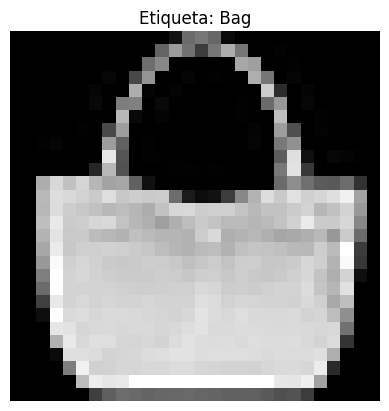

In [ ]:
# Posición de la imagen a mostrar
pos = 100

# Mostrar imagen con etiqueta en texto
plt.imshow(x_train[pos], cmap='gray')
plt.title(f"Etiqueta: {y_train_text[pos]}")
plt.axis("off")
plt.show()

Al seleccionar una imagen aleatoria del dataset, podemos comprender los datos que trabajamos, darnos una idea de que características se podrían seleccionar para clasificar los diferentes tipos de objetos. En este caso, prendas se ropa.

# **Creación del modelo CNN con hiperparámetros ajustables**

In [ ]:
# Función para construir el modelo
def build_model(hp):
    model = keras.Sequential()

    # Capa convolucional con rango reducido de filtros
    model.add(Conv2D(
        filters=hp.Int('filters', min_value=32, max_value=64, step=32),  # Máximo 64 en lugar de 128
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(28, 28, 1)
    ))
    model.add(MaxPooling2D(2, 2))

    # Capa densa con menos opciones de unidades
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('units', min_value=64, max_value=128, step=64),  # Máximo 128 en lugar de 256
        activation='relu'
    ))

    # Capa de salida
    model.add(Dense(10, activation='softmax'))

    # Solo un optimizador para reducir combinaciones
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam']),  # Eliminamos 'sgd' para reducir combinaciones
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# **Creación del Tuner**

Esto nos ayuda a buscar la mejor combinación de hiperparámetros.


In [ ]:
# Crear el tuner optimizado
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=3,  # Reducido de 5 a 3 para tuning más rápido
    factor=2,  # Prueba menos combinaciones
    directory='tuning_dir',
    project_name='cnn_tuning'
)

# Usar una parte del dataset para tuning
x_train_sample = x_train[:10000]  # Usamos solo 10,000 imágenes
y_train_sample = y_train[:10000]

# Iniciar búsqueda de hiperparámetros con menos épocas
tuner.search(x_train_sample, y_train_sample, epochs=3, validation_data=(x_test[:2000], y_test[:2000]))

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Mejor número de filtros: {best_hps.get('filters')}")
print(f"Mejor número de neuronas: {best_hps.get('units')}")
print(f"Mejor optimizador: {best_hps.get('optimizer')}")

Reloading Tuner from tuning_dir/cnn_tuning/tuner0.json
Mejor número de filtros: 96
Mejor número de neuronas: 128
Mejor optimizador: adam


# **Entrenar el modelo**

In [ ]:
# Construir modelo con los mejores hiperparámetros encontrados
best_model = tuner.hypermodel.build(best_hps)

# Callbacks para detener entrenamiento si no mejora
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Entrenar modelo optimizado
history = best_model.fit(
    x_train[:20000], y_train[:20000],  # Solo 20,000 muestras para entrenar más rápido
    epochs=10,
    batch_size=64,  # Tamaño de batch mayor para acelerar en CPU
    validation_data=(x_test[:5000], y_test[:5000]),  # Solo 5,000 imágenes de validación
    callbacks=[early_stopping]  # Detiene si no mejora en 3 epochs
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.7362 - loss: 0.7280 - val_accuracy: 0.8720 - val_loss: 0.3865
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.8843 - loss: 0.3349 - val_accuracy: 0.8488 - val_loss: 0.4195
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.9020 - loss: 0.2703 - val_accuracy: 0.8860 - val_loss: 0.3304
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.9178 - loss: 0.2232 - val_accuracy: 0.8882 - val_loss: 0.3158
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.9304 - loss: 0.1962 - val_accuracy: 0.8890 - val_loss: 0.3214
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.9347 - loss: 0.1698 - val_accuracy: 0.8892 - val_loss: 0.3240
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.9478 - loss: 0.1426 - val_accuracy: 0.8812 - val_loss: 0.3570
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.9565 - loss: 0.1188 - 

# **Evaluar precisión del modelo**

In [ ]:
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f"Precisión en test: {test_acc:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8963 - loss: 0.3315
Precisión en test: 0.8943


# **Prediciones del modelo**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2


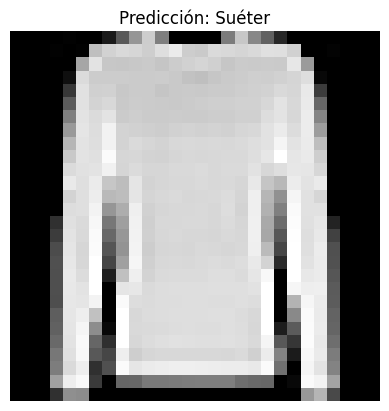

In [ ]:
# Elegir una imagen de prueba aleatoria
index = np.random.randint(len(x_test))
image = x_test[index]

# Predecir
pred = best_model.predict(np.expand_dims(image, axis=0))
print(np.argmax(pred))
predicted_label = label_map[np.argmax(pred)]

# Mostrar la imagen y la predicción
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Predicción: {predicted_label}")
plt.axis("off")
plt.show()